# Finetuning Segment Anything with `µsam`

This notebook shows how to use Segment Anything for Microscopy to fine-tune a Segment Anything Model (SAM) on the SEM grain data from Zeiss. 

(this is a derivative of the [micro-sam fine tuning](https://github.com/computational-cell-analytics/micro-sam/blob/master/notebooks/sam_finetuning.ipynb) example)

We use SEM grain images from [this Question](https://forum.image.sc/t/free-article-from-machine-learning-to-deep-learning-revolutionizing-microscopy-image-analysis/106340).

## Running this notebook

If you have an environment with `µsam` on your computer you can run this notebook in there. You can follow the [installation instructions](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#installation) to install it on your computer.

You can also run this notebook in the cloud on [Kaggle Notebooks](https://www.kaggle.com/code/). This service offers free usage of a GPU to speed up running the code. The next cells will take care of the installation for you if you are using it.

In [1]:
import torch
import os
print(torch.cuda.is_available())  # Returns True if a GPU is available

print(torch.cuda.current_device())  # Returns the current GPU device index
print(torch.cuda.device_count())    # Number of available GPUs
print(torch.cuda.get_device_name(0))  # Name of the first GPU (if available)

True
0
1
NVIDIA GeForce RTX 3090


### Importing the libraries

In [2]:
import warnings
import os
from tnia.plotting.plt_helper import random_label_cmap
warnings.filterwarnings("ignore")
import micro_sam

print(f"Using micro_sam version {micro_sam.__version__}")

from glob import glob
from IPython.display import FileLink

import numpy as np
import imageio.v3 as imageio
from matplotlib import pyplot as plt
from skimage.measure import label as connected_components

import torch

from torch_em.util.debug import check_loader
from torch_em.data import MinInstanceSampler
from torch_em.util.util import get_random_colors

import micro_sam.training as sam_training
from micro_sam.sample_data import fetch_tracking_example_data, fetch_tracking_segmentation_data
from micro_sam.automatic_segmentation import get_predictor_and_segmenter, automatic_instance_segmentation

Using micro_sam version 1.5.0


## Set paths

In [3]:
parent_path = r'D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2'
parent_path = r'D:\images\tnia-python-images\imagesc\2025_06_21_tough_cellpose_subset'
train_path = os.path.join(parent_path, 'patches')
model_path = os.path.join(parent_path, 'models')

segmentation_dir = train_path + '/ground truth0'
image_dir = train_path + '/input0'

## convert to 8 bit

For micro-sam inputs must be in 8 bit. 

In [4]:
image_dir_255 = train_path + '/input0_255'

# if no 8-bit images yet make them
if not os.path.exists(image_dir_255):
    os.makedirs(image_dir_255)

    image_paths = sorted(glob(os.path.join(image_dir, "*")))

    for image_path in image_paths:
        image = imageio.imread(image_path)
        image = (image * 255).astype('uint8')
        imageio.imwrite(image_path.replace(image_dir, image_dir_255), image)


### Let's create the dataloaders

Our task is to segment HeLa cells on a flat glass in DIC microscopic images. The dataset comes from https://celltrackingchallenge.net/2d-datasets/, and the dataloader has been implemented in [torch-em](https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/ctc.py).

#### First, let's visualize how our samples look.

num images is 100
num segmentations is 100
image size is (256, 256, 3)


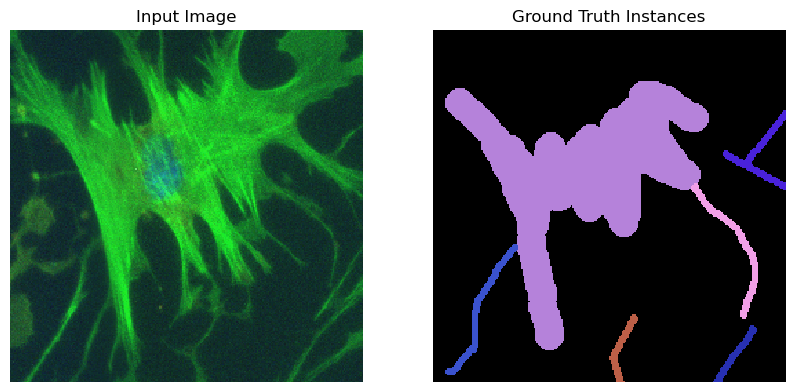

In [5]:

image_dir = image_dir_255
image_paths = sorted(glob(os.path.join(image_dir, "*")))
print('num images is', len(image_paths))
segmentation_paths = sorted(glob(os.path.join(segmentation_dir, "*")))
print('num segmentations is', len(segmentation_paths))

for image_path, segmentation_path in zip(image_paths, segmentation_paths):
    image = imageio.imread(image_path)
    print('image size is', image.shape)
    segmentation = imageio.imread(segmentation_path)

    fig, ax = plt.subplots(1, 2, figsize=(10, 10))

    ax[0].imshow(image, cmap="gray")
    ax[0].set_title("Input Image")
    ax[0].axis("off")

    segmentation = connected_components(segmentation)
    ax[1].imshow(segmentation, cmap=random_label_cmap(), interpolation="nearest")
    ax[1].set_title("Ground Truth Instances")
    ax[1].axis("off")

    plt.show()
    plt.close()

    break  # comment this out in case you want to visualize all the images

In [6]:
# 'micro_sam.training.default_sam_loader' is a convenience function to build a pytorch dataloader from image data and labels for training segmentation models.
# This is wrapped around the 'torch_em.default_segmentation_loader'.
# It supports image data in various formats.
# Here, we load image data and labels from the two folders with tif images that were downloaded by the example data functionality,
# by specifying `raw_key` and `label_key` as `*.tif`.
# This means all images in the respective folders that end with .tif will be loaded.
# The function supports many other file formats. For example, if you have tif stacks with multiple slices instead of multiple tif images in a folder,
# then you can pass 'raw_key=label_key=None'.
# For more information, here is the documentation: https://github.com/constantinpape/torch-em/blob/main/torch_em/data/datasets/README.md
# And here is a tutorial on creating dataloaders using 'torch-em': https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb

# Load images from multiple files in folder via pattern (here: all tif files)
raw_key, label_key = "*.tif", "*.tif"

# Alternative: if you have tif stacks you can just set 'raw_key' and 'label_key' to None
# raw_key, label_key= None, None

# The 'roi' argument can be used to subselect parts of the data.
# Here, we use it to select the first 70 images (frames) for the train split and the other frames for the val split.
train_roi = np.s_[:1180, :, :]
val_roi = np.s_[1180:1200, :, :]

In [ ]:
# The script below returns the train or val data loader for finetuning Segment Anything Model (SAM).
# The data loader must be a torch data loader that returns `x, y` tensors, where `x` is the image data and `y` are the labels.
# The labels have to be in a label mask instance segmentation format.
# i.e. a tensor of the same spatial shape as `x`, with each object mask having its own ID.
# Important: the ID 0 is reseved for background, and the IDs must be consecutive
i
# Here, we use `micro_sam.training.default_sam_loader` for creating a suitable data loader from
# the example hela data. You can either adapt this for your own data or write a suitable torch dataloader yourself.
# Here's a quickstart notebook to create your own dataloaders: https://github.com/constantinpape/torch-em/blob/main/notebooks/tutorial_create_dataloaders.ipynb

batch_size = 1  # the training batch size
patch_shape = (1, 512, 512)  # the size of patches for training

# Train an additional convolutional decoder for end-to-end automatic instance segmentation
# NOTE 1: It's important to have densely annotated-labels while training the additional convolutional decoder.
# NOTE 2: In case you do not have labeled images, we recommend using `micro-sam` annotator tools to annotate as many objects as possible per image for best performance.
train_instance_segmentation = True

# NOTE: The dataloader internally takes care of adding label transforms: i.e. used to convert the ground-truth
# labels to the desired instances for finetuning Segment Anythhing, or, to learn the foreground and distances
# to the object centers and object boundaries for automatic segmentation.

# There are cases where our inputs are large and the labeled objects are not evenly distributed across the image.
# For this we use samplers, which ensure that valid inputs are chosen subjected to the paired labels.
# The sampler chosen below makes sure that the chosen inputs have atleast one foreground instance, and filters out small objects.
sampler = MinInstanceSampler(min_size=1)  # NOTE: The choice of 'min_size' value is paired with the same value in 'min_size' filter in 'label_transform'.

train_loader = sam_training.default_sam_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    rois=None,#train_roi,
    shuffle=True,
    raw_transform=sam_training.identity,
    sampler=sampler,
    #with_channels = True,
)

val_loader = sam_training.default_sam_loader(
    raw_paths=image_dir,
    raw_key=raw_key,
    label_paths=segmentation_dir,
    label_key=label_key,
    with_segmentation_decoder=train_instance_segmentation,
    patch_shape=patch_shape,
    batch_size=batch_size,
    is_seg_dataset=True,
    rois=None, #val_roi,
    shuffle=True,
    raw_transform=sam_training.identity,
    sampler=sampler,
    #with_channels = True, 
)

D:\images\tnia-python-images\imagesc\2025_06_21_tough_cellpose_subset\patches/input0_255 D:\images\tnia-python-images\imagesc\2025_06_21_tough_cellpose_subset\patches/ground truth0 None
D:\images\tnia-python-images\imagesc\2025_06_21_tough_cellpose_subset\patches/input0_255 D:\images\tnia-python-images\imagesc\2025_06_21_tough_cellpose_subset\patches/ground truth0 None
D:\images\tnia-python-images\imagesc\2025_06_21_tough_cellpose_subset\patches/input0_255 D:\images\tnia-python-images\imagesc\2025_06_21_tough_cellpose_subset\patches/ground truth0 None
D:\images\tnia-python-images\imagesc\2025_06_21_tough_cellpose_subset\patches/input0_255 D:\images\tnia-python-images\imagesc\2025_06_21_tough_cellpose_subset\patches/ground truth0 None


In [8]:
test = train_loader.dataset[0]
test[0].shape, test[1].shape

(torch.Size([3, 512, 512]), torch.Size([4, 512, 512]))

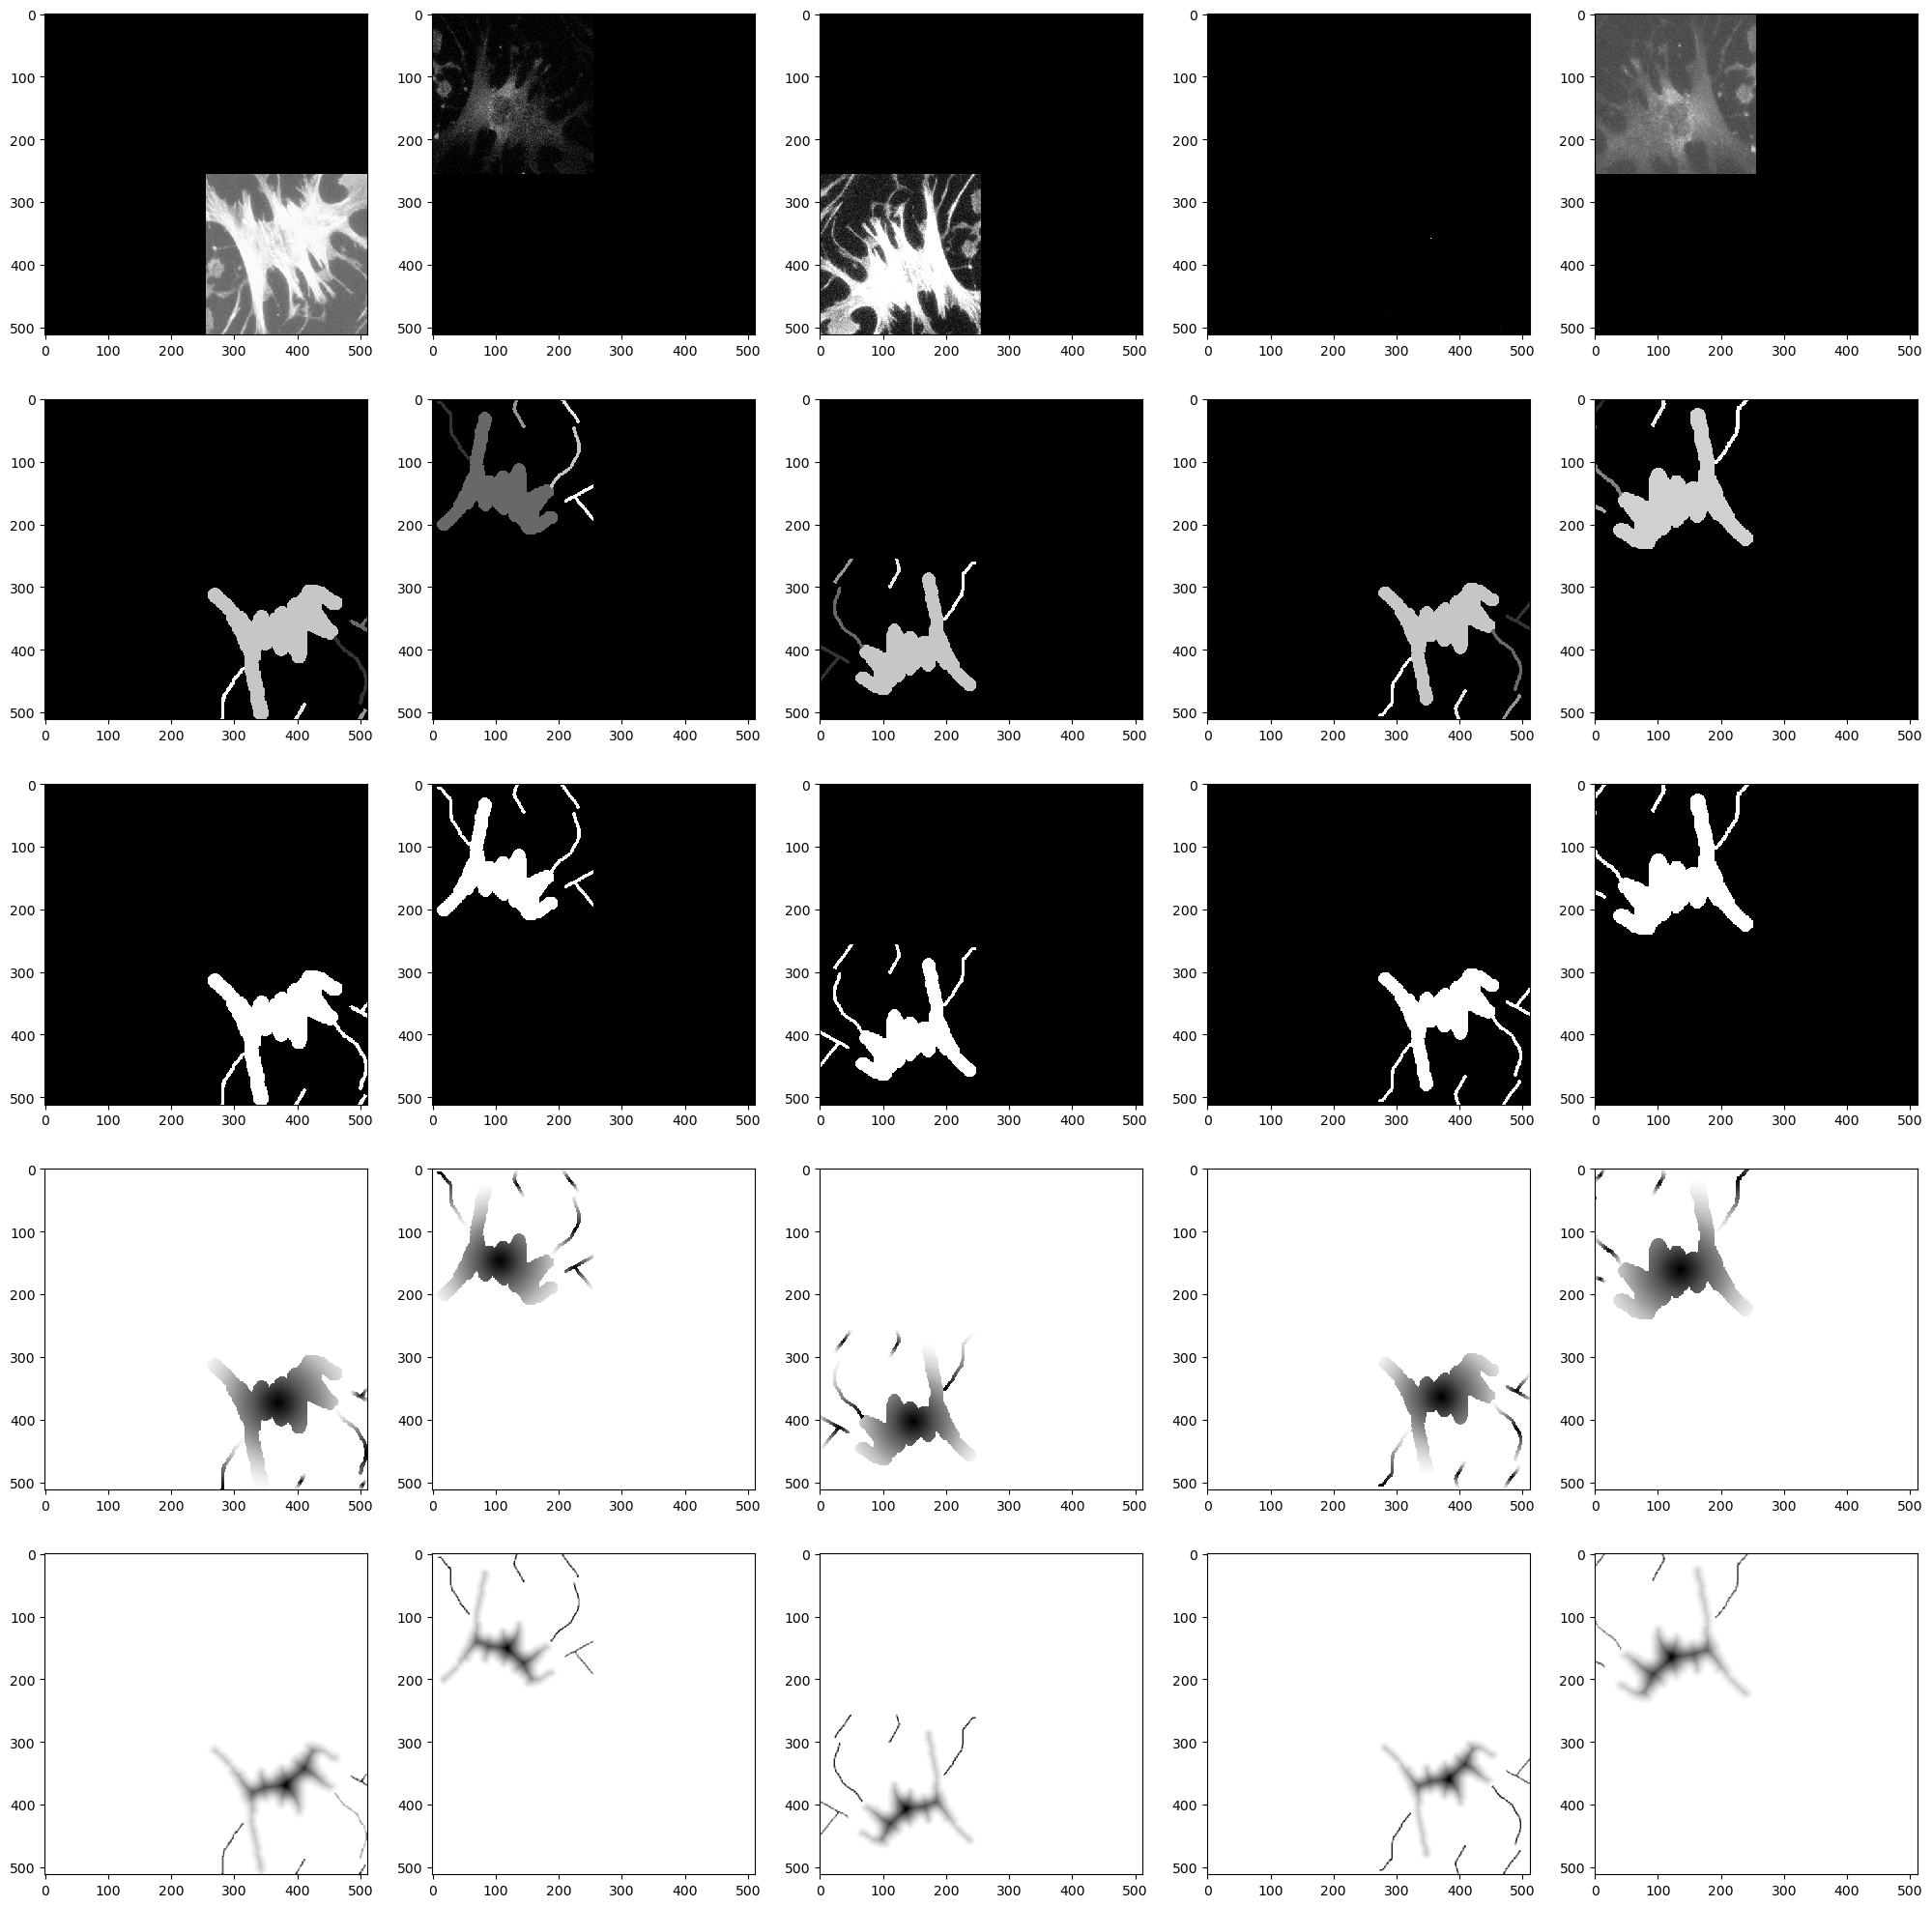

In [9]:
# Let's check how our samples look from the dataloader
check_loader(train_loader, 5, plt=True)

### Run the actual model finetuning

In [10]:
# All hyperparameters for training.
n_objects_per_batch = 2  # the number of objects per batch that will be sampled
device = "cuda" if torch.cuda.is_available() else "cpu" # the device/GPU used for training
n_epochs = 2  # how long we train (in epochs)

# The model_type determines which base model is used to initialize the weights that are finetuned.
# We use vit_b here because it can be trained faster. Note that vit_h usually yields higher quality results.
model_type = "vit_b"

# The name of the checkpoint. The checkpoints will be stored in './checkpoints/<checkpoint_name>'
checkpoint_name = "microsam_1.5_vitb"

**NOTE**: The user needs to decide whether to finetune the Segment Anything model, or the `µsam`'s "finetuned microscopy models" for their dataset. Here, we finetune on the Segment Anything model for simplicity. For example, if you choose to finetune the model from the light microscopy generalist models, you need to update the `model_type` to `vit_b_lm` and it takes care of initializing the model with the desired weights)

In [11]:
help(sam_training.train_sam)

Help on function train_sam in module micro_sam.training.training:

train_sam(name: str, model_type: str, train_loader: torch.utils.data.dataloader.DataLoader, val_loader: torch.utils.data.dataloader.DataLoader, n_epochs: int = 100, early_stopping: Optional[int] = 10, n_objects_per_batch: Optional[int] = 25, checkpoint_path: Union[str, os.PathLike, NoneType] = None, with_segmentation_decoder: bool = True, freeze: Optional[List[str]] = None, device: Union[str, torch.device, NoneType] = None, lr: float = 1e-05, n_sub_iteration: int = 8, save_root: Union[str, os.PathLike, NoneType] = None, mask_prob: float = 0.5, n_iterations: Optional[int] = None, scheduler_class: Optional[torch.optim.lr_scheduler._LRScheduler] = <class 'torch.optim.lr_scheduler.ReduceLROnPlateau'>, scheduler_kwargs: Optional[Dict[str, Any]] = None, save_every_kth_epoch: Optional[int] = None, pbar_signals: Optional[PyQt5.QtCore.QObject] = None, optimizer_class: Optional[torch.optim.optimizer.Optimizer] = <class 'torch.opt

In [ ]:
# Run training (best metric 0.027211)
sam_training.train_sam(
    name=checkpoint_name,
    save_root=model_path, #os.path.join(root_dir, "models"),
    model_type=model_type,
    train_loader=train_loader,
    val_loader=val_loader,
    n_epochs=n_epochs,
    n_objects_per_batch=n_objects_per_batch,
    with_segmentation_decoder=train_instance_segmentation,
    device=device,
)

Verifying labels in 'val' dataloader: 100%|██████████| 50/50 [00:02<00:00, 17.93it/s]


Start fitting for 200 iterations /  2 epochs
with 100 iterations per epoch
Training with mixed precision


Epoch 0:  10%|▉         | 19/200 [00:17<02:32,  1.19it/s]

In [11]:
# Let's spot our best checkpoint and download it to get started with the annotation tool
best_checkpoint = os.path.join(model_path, "checkpoints", checkpoint_name, "best.pt")

# Download link is automatically generated for the best model.
print("Click here \u2193")
FileLink(best_checkpoint)

Click here ↓


D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2\models\checkpoints\microsam_1.5_vitb\best.pt

### Let's run the automatic instance segmentation (AIS)

In [15]:
def run_automatic_instance_segmentation(image, checkpoint_path, model_type="vit_b_lm", device=None, tile_shape = None, halo = None):
    """Automatic Instance Segmentation (AIS) by training an additional instance decoder in SAM.

    NOTE: AIS is supported only for `µsam` models.

    Args:
        image: The input image.
        checkpoint_path: The path to stored checkpoints.
        model_type: The choice of the `µsam` model.
        device: The device to run the model inference.

    Returns:
        The instance segmentation.
    """
    # Step 1: Get the 'predictor' and 'segmenter' to perform automatic instance segmentation.
    predictor, segmenter = get_predictor_and_segmenter(
        model_type=model_type, # choice of the Segment Anything model
        checkpoint=checkpoint_path,  # overwrite to pass your own finetuned model.
        device=device,  # the device to run the model inference.
        is_tiled = (tile_shape is not None),  # whether the model is tiled or not.
    )

    # Step 2: Get the instance segmentation for the given image.
    prediction = automatic_instance_segmentation(
        predictor=predictor,  # the predictor for the Segment Anything model.
        segmenter=segmenter,  # the segmenter class responsible for generating predictions.
        input_path=image,
        ndim=2,
        tile_shape=tile_shape,
        halo=halo,
    )

    return prediction

Merge segmentation: 100%|██████████| 1/1 [00:00<00:00, 43.48it/s]


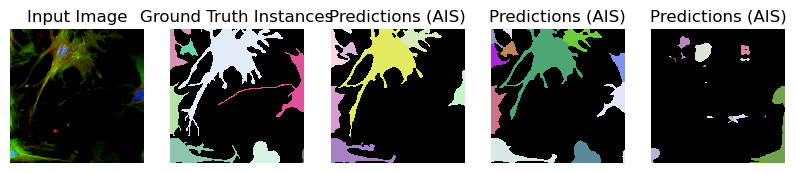

Merge segmentation: 100%|██████████| 1/1 [00:00<00:00, 22.22it/s]


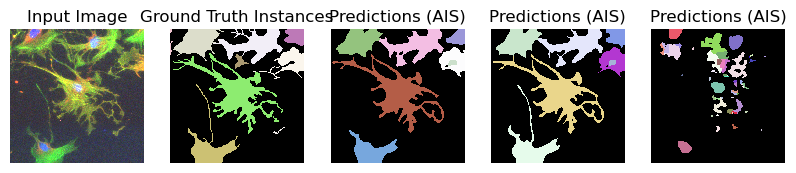

Merge segmentation: 100%|██████████| 1/1 [00:00<00:00, 43.49it/s]


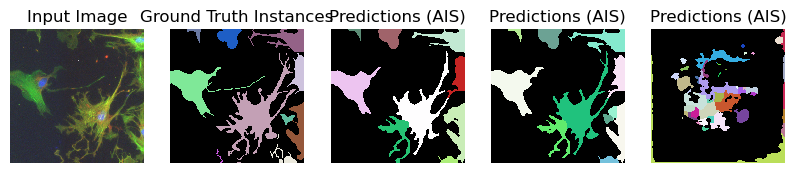

Merge segmentation: 100%|██████████| 1/1 [00:00<00:00, 45.45it/s]


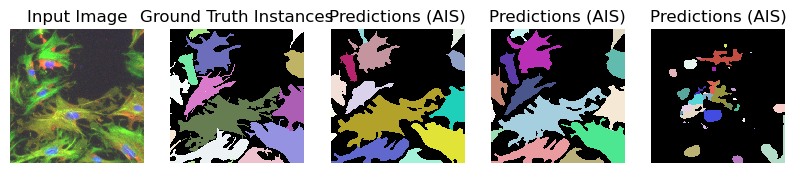

Merge segmentation: 100%|██████████| 1/1 [00:00<00:00, 34.48it/s]


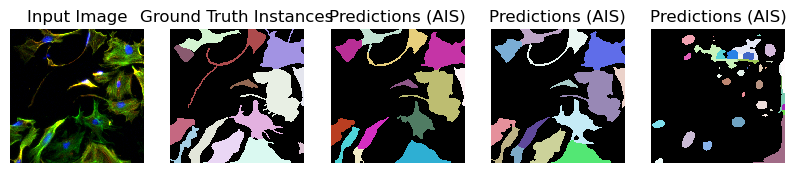

In [13]:
assert os.path.exists(best_checkpoint), "Please train the model first to run inference on the finetuned model."
assert train_instance_segmentation is True, "Oops. You didn't opt for finetuning using the decoder-based automatic instance segmentation."

# Let's check the first 5 images. Feel free to comment out the line below to run inference on all images.
image_paths_ = image_paths[:5]
segmentation_paths_ = segmentation_paths[:5]

for image_path, segmentation_path in zip(image_paths_, segmentation_paths_):
    image = imageio.imread(image_path)
    image_ = np.transpose(image, (2, 0, 1))
    segmentation = imageio.imread(segmentation_path)

    # Predicted instances
    prediction = run_automatic_instance_segmentation(
        image=image_, checkpoint_path=best_checkpoint, model_type=model_type, device=device
    )

    # Visualize the predictions
    fig, ax = plt.subplots(1, 5, figsize=(10, 10))

    ax[0].imshow(image, cmap="gray")
    ax[0].axis("off")
    ax[0].set_title("Input Image")

    ax[1].imshow(segmentation, cmap=random_label_cmap(), interpolation="nearest")
    ax[1].axis("off")
    ax[1].set_title("Ground Truth Instances")
    
    ax[2].imshow(prediction[0], cmap=random_label_cmap(), interpolation="nearest")
    ax[2].axis("off")
    ax[2].set_title("Predictions (AIS)")
    
    ax[3].imshow(prediction[1], cmap=random_label_cmap(), interpolation="nearest")
    ax[3].axis("off")
    ax[3].set_title("Predictions (AIS)")
    
    ax[4].imshow(prediction[2], cmap=random_label_cmap(), interpolation="nearest")
    ax[4].axis("off")
    ax[4].set_title("Predictions (AIS)")

    plt.show()
    plt.close()
    #break

Merge segmentation: 100%|██████████| 1/1 [00:00<00:00, 20.80it/s]


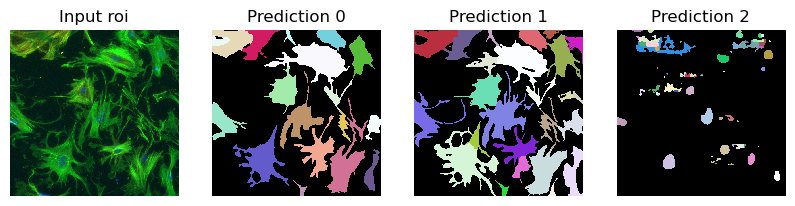

In [14]:
im = imageio.imread(r"D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2\img52.tif")
im_ = np.transpose(im, (2, 0, 1))

prediction = run_automatic_instance_segmentation(
    image=im_, checkpoint_path=best_checkpoint, model_type=model_type, device=device, tile_shape=(384, 384), halo = (64, 64)
    #image=im_whole, checkpoint_path=best_checkpoint, model_type=model_type, device=device
)

# Visualize the predictions
fig, ax = plt.subplots(1, 4, figsize=(10, 10))

ax[0].imshow(im//255, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Input roi")
ax[1].imshow(prediction[0], cmap=random_label_cmap(), interpolation="nearest")
ax[1].axis("off")
ax[1].set_title("Prediction 0")
ax[2].imshow(prediction[1], cmap=random_label_cmap(), interpolation="nearest")
ax[2].axis("off")
ax[2].set_title("Prediction 1")
ax[3].imshow(prediction[2], cmap=random_label_cmap(), interpolation="nearest")
ax[3].axis("off")
ax[3].set_title("Prediction 2")


plt.show()
plt.close()


Compute Image Embeddings 2D tiled: 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]
Initialize tiled instance segmentation with decoder: 100%|██████████| 4/4 [00:00<00:00, 12.12it/s]


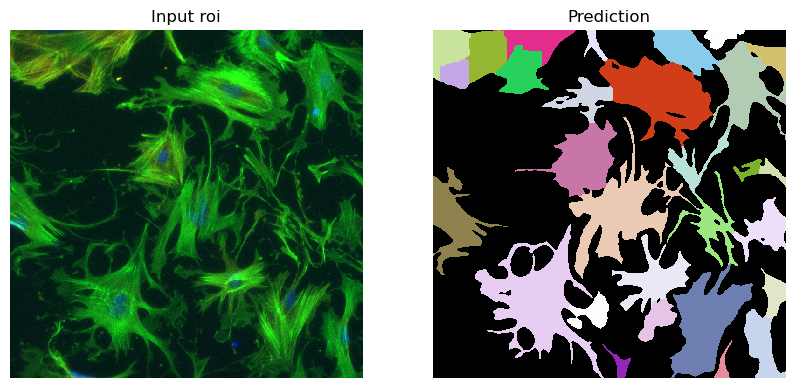

In [17]:
im = imageio.imread(r"D:\images\tnia-python-images\imagesc\2024_10_11_tough_cellpose_2\img52.tif")

prediction = run_automatic_instance_segmentation(
    image=im, checkpoint_path=best_checkpoint, model_type=model_type, device=device, tile_shape=(384, 384), halo = (64, 64)
    #image=im_whole, checkpoint_path=best_checkpoint, model_type=model_type, device=device
)

# Visualize the predictions
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(im//255, cmap="gray")
ax[0].axis("off")
ax[0].set_title("Input roi")
ax[1].imshow(prediction, cmap=random_label_cmap(), interpolation="nearest")
ax[1].axis("off")
ax[1].set_title("Prediction")

plt.show()
plt.close()


In [18]:
import napari

viewer = napari.Viewer()

viewer.add_image(im, name="Input Image", colormap="gray")
viewer.add_labels(prediction[1], name="Predictions (AIS)")

<Labels layer 'Predictions (AIS)' at 0x2906579e590>

### What next?

It's time to get started with your custom finetuned model using the annotator tool. Here is the documentation on how to get started with `µsam`: [Annotation Tools](https://computational-cell-analytics.github.io/micro-sam/micro_sam.html#annotation-tools)

Happy annotating!

*This notebook was last ran on October 20, 2024*